# ResNet

기존의 논문들은 깊이가 엄청 깊어지게 되면 성능이 나빠지는 현상을 보인다.

그 이유는 gradient vanishing 문제가 발생하기 때문이다. 계속 미분하게 되면 뒤 쪽의 layer들의 기울기는 0에 가까워지기 때문에 학습이 잘 되지 않는다.

이 논문에서는 그러한 문제를 해결하였다.

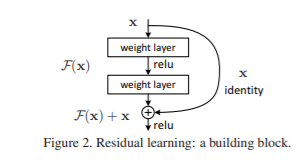

앞의 입력을 뒤 쪽으로 끌고와 더한다.


기존에는 h(x)를 예측하여야 했다.
이 논문은 h(x) = f(x) + x 꼴이다.
f(x) = h(x) - x 로 나타낼 수 있다. 이것이 의미하는 바는 h(x) 에서 x를 잔차라고 하고, 이것을 학습하는 것이 residual learning 이라고 한다.


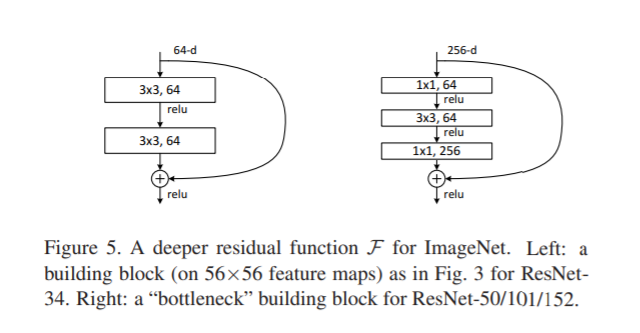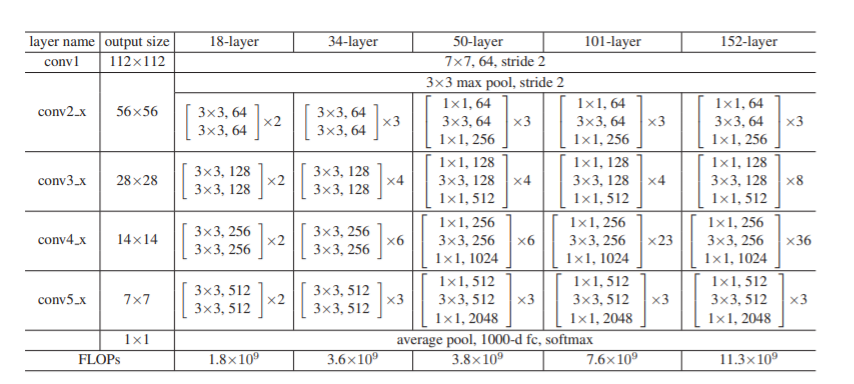




resnet 34만 구현해보겠다.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output


In [ ]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels,stride=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.downsample = nn.Sequential()

    # 더하기 위해서는 모양을 맞추줘야 됨.
    if stride != 1 or in_channels != out_channels:
      self.downsample = nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
          
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out += self.downsample(x)
    out = F.relu(out)
      
    return out
  
  


In [ ]:
class ResNet34(nn.Module):
  def __init__(self, block, num_blocks= [3,4,6,3], num_classes = 10):
    super().__init__()
    self.in_channels = 64

    self.conv1 = nn.Sequential(
        nn.Conv2d(3,64, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.conv2_x = self._make_layer(block, 64, num_blocks[0], 1)
    self.conv3_x = self._make_layer(block, 128, num_blocks[1], 2)
    self.conv4_x = self._make_layer(block, 256, num_blocks[2], 2)
    self.conv5_x = self._make_layer(block, 512, num_blocks[3], 2)
    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512, num_classes)

  
  def _make_layer(self, block, out_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks -1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_channels, out_channels, stride))
      self.in_channels = out_channels
    
    return nn.Sequential(*layers)
  
  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2_x(out)
    out = self.conv3_x(out)
    out = self.conv4_x(out)
    out = self.conv5_x(out)
    out = self.avg_pool(out)
    out = out.view(out.size(0), -1)
    out = self.fc(out)

    return out






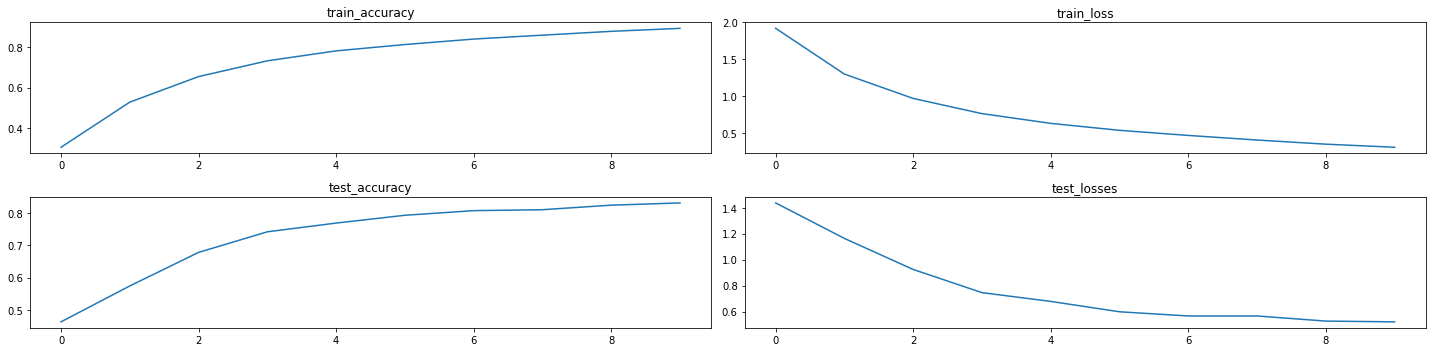

In [ ]:
def plot(epochs, train_losses, train_accs, test_losses, test_accs):
  clear_output()
  plt.figure(figsize = (20,5))
  plt.title('epoch {0}'.format(epochs[-1]))
  plt.subplot(221)
  plt.title('train_accuracy')
  plt.plot(train_accs)
  plt.subplot(222)
  plt.title('train_loss')
  plt.plot(train_losses)
  plt.subplot(223)
  plt.title('test_accuracy')
  plt.plot(test_accs)
  plt.subplot(224)
  plt.title('test_losses')
  plt.plot(test_losses)
  plt.tight_layout()
  plt.show()


def fit(model, epochs, device, optimizer, criterion, train_loader, test_loader):
  epoch_range = []
  
  train_losses = []
  test_losses = []

  train_accs = []
  test_accs = []
  i = 1

  model.to(device)
  for epoch in range(epochs):


    train_loss = 0.
    train_acc = 0.

    model.train()
    for data, target in train_loader:
      data = data.to(device)
      target = target.to(device)

      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()

      acc = (output.argmax(dim=1) == target).float().mean()
      train_loss += loss
      train_acc += acc

      optimizer.step()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)


    test_loss, test_acc = 0., 0.

    model.eval()
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)

      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
        acc = (output.argmax(dim=1)==target).float().mean()
        
        test_loss += loss
        test_acc += acc

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    test_losses.append(test_loss)
    test_accs.append(test_acc)

    epoch_range.append(i)
    i += 1
        
    plot(epoch_range, train_losses, train_accs, test_losses, test_accs)


def run(model):
  NUM_EPOCHS = 10
  BATCH_SIZE =64
  LR = 0.01

  train_transform = transforms.Compose([
        transforms.Resize(24),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
  ])


  test_transform = transforms.Compose([
                                      transforms.Resize(24),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
  ])

  train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

  test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

  optimizer = optim.Adam(params=model.parameters(), lr=LR)

  criterion = nn.CrossEntropyLoss()

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  fit(model, NUM_EPOCHS, device, optimizer, criterion, train_loader, test_loader)

model = ResNet34(BasicBlock)

run(model)


# SENet

SENet은 채널 간의 가중치를 주어서 학습을 한다.

그리고 다른 model에 결합하기가 쉽고, 결합할 경우에는 성능이 향상되는 것을 보여준다.

앞에서 구현한 resnet34에 SENet을 결합해 볼 것이다.(논문에서는 resnet50 에 결합한다.)

![1](./1.PNG)

X를 convolution 해서 U가 나온다. 

![2](./2.PNG)

이 연산을 Squeeze 라고 한다. 
이 식은 복잡해보이지만, pytorch 에서 nn.AdpativePool2d((1,1))이라고 보면 된다. 채널마다 h x w의 평균을 구해준다.

그리고 이 정보들을 aggregated 하기 위해서는 Excitaion이라는 연산을 이용해준다.

![3](./3.PNG)

W1은 fc layer의 파라미터라고 생각하면 된다. 이는 c/r(r은 ratio) 만큼 채널을 줄인다. 그리고 이를 ReLu함수에 넣는다. 이 결과물을 또 W2로 계산해서 채널을 원래대로 되돌려주고 이를 sigmoid 함수에 넣는다.


이는 0 ~ 1 사이의 값을 내놓게 된다.

![4](./4.PNG)

마지막으로 앞에서 구한 가중치들을 곱해주면 된다. 여기서 sigmoid한 이유가 나온다.

![5](./5.PNG)

이는 ResNet에 SENet을 결합한 예시이다. resnet50에서는 r을 16으로 설정했다고 한다.





In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channels, r=16):
        super().__init__()
        self.channels = channels
        self.adv_pool = nn.AdaptiveAvgPool2d((1,1))
        
        self.fc1 = nn.Sequential(
            nn.Linear(channels, channels//r),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(channels//r, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.adv_pool(x)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = out.view(out.size(0), self.channels, 1,1)
        out = x*out
        
        return out


In [ ]:
class SEResNetBasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.downsample = nn.Sequential()
    
    self.seblock = SEBlock(out_channels)
    self.downsample = nn.Sequential()

    # 더하기 위해서는 모양을 맞추줘야 됨.
    if stride != 1 or in_channels != out_channels:
      self.downsample = nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU()
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    #추가 된 부분.
    out = self.seblock(out)
    out += self.downsample(x)
    out = F.relu(out)
      
    return out

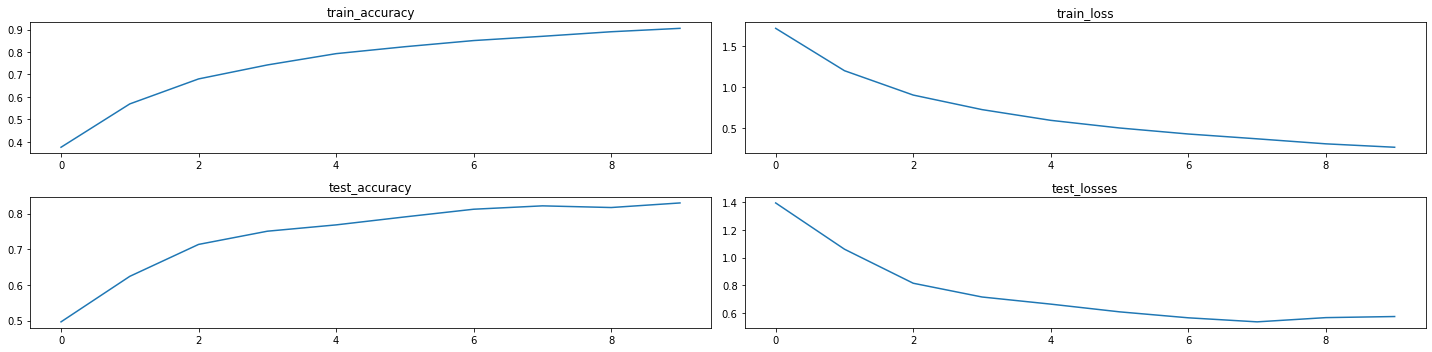

In [ ]:
torch.cuda.empty_cache()
model = ResNet34(SEResNetBasicBlock)

run(model)